# Oil-Visio
A deep learning model which is used for detecting visual defects in ball bearings such as scratches and honing defects.

It performs the following functions:
- Preprocess the image to reduce effect of glare from Oil and stensol
- View bearing from multiple angles (both top and side) and make prediction
- The model will classify the bearing whether it is defective from top/side or not.

This model is intended to display it's prediction in a mobile or web application.

#Importing Dataset
---
Fetching training images for both side and top view from Google Drive.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!rm -r dataset

In [0]:
#Unzips all the images
!7z x Dataset_Images.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 156228742 bytes (149 MiB)

Extracting archive: Dataset_Images.zip
--
Path = Dataset_Images.zip
Type = zip
Physical Size = 156228742

  0%     16% 5 - Skf Images/false/20190228_181114.jpg                                              33% 9 - Skf Images/false/20190228_181805.jpg                                              50% 17 - Skf Images/true/20190228_173100.jpg                                              67% 21 - Skf Images/true/20190228_1

#Importing Libraries

In [0]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [0]:
img = cv2.imread('IMG_20190302_103542-2.jpg', cv2.IMREAD_COLOR)
img.shape

(1889, 2469, 3)

# Preprocessing Images
---
Removing Glare from the images using Opencv Inpainting.<br>
This allows increased classification accuracy and reduction of effects of Stensol and Oil.


##Basic Process Behind H,S,V Glare Reduction

##Defective Bearing

###Display Original Image

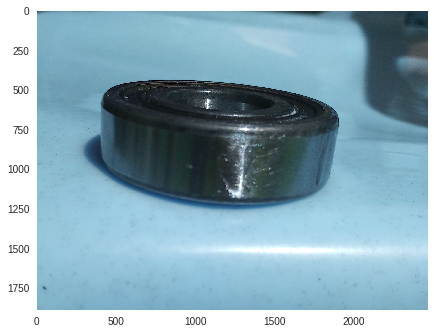

In [0]:
#img = cv2.resize(cv2.imread('IMG_20190302_103542-2.jpg', cv2.IMREAD_COLOR),None,fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
plt.grid(None)
imgplot = plt.imshow(img)

###Split into H, S, V

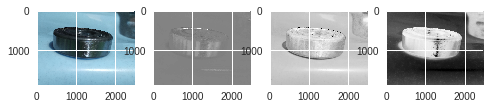

In [0]:
h, s, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2HSV)) # split into HSV components

plt.subplot(1,4,1).imshow(img)
plt.subplot(1,4,2).imshow(h)
plt.subplot(1,4,3).imshow(s)
plt.subplot(1,4,4).imshow(v)

###Detect Glare and Display Saturation in Image

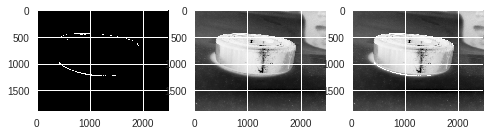

In [0]:
nonSat = s < 180 # Find all pixels that are not very saturated

# Slightly decrease the area of the non-satuared pixels by a erosion operation.
disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
nonSat = cv2.erode(nonSat.astype(np.uint8), disk)

# Set all brightness values, where the pixels are still saturated to 0.
v2 = v.copy()
v2[nonSat == 0] = 0;

plt.subplot(1,3,1).imshow(nonSat)
plt.subplot(1,3,2).imshow(v)
plt.subplot(1,3,3).imshow(v2)

###Preparing and applying mask to correct Image

In [0]:
glare = v2 > 200;    # filter out very bright pixels.
# Slightly increase the area for each pixel
glare = cv2.dilate(glare.astype(np.uint8), disk);  
glare = cv2.dilate(glare.astype(np.uint8), disk);

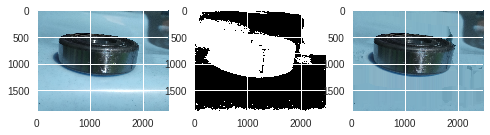

In [0]:
corrected = cv2.inpaint(img, glare, 5, cv2.INPAINT_NS)
plt.subplot(1,3,1).imshow(img)
plt.subplot(1,3,2).imshow(glare)
plt.subplot(1,3,3).imshow(corrected);

### Comparison of Original and Processed Image for Defective Bearing


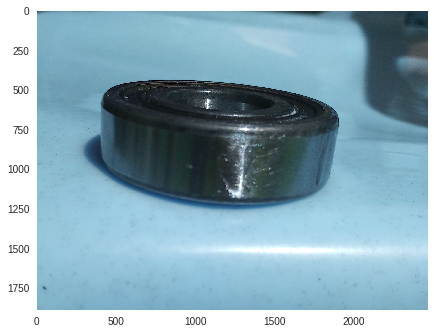

In [0]:
plt.grid(None)
plt.imshow(img)

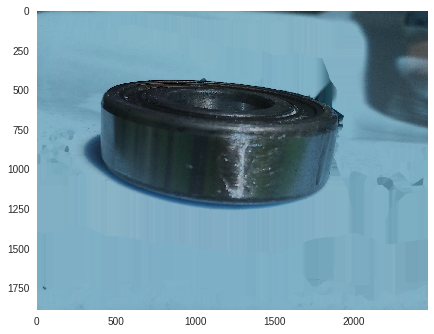

In [0]:
plt.grid(None)
plt.imshow(corrected)

##Non-Defective Bearing

###Applying Preprocessing Steps

In [0]:
img2 = cv2.resize(cv2.imread('Oil-NonDefect.jpg', cv2.IMREAD_COLOR),(1000,750), interpolation = cv2.INTER_CUBIC)
h, s, v = cv2.split(cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)) # split into HSV components
nonSat = s < 180 # Find all pixels that are not very saturated

# Slightly decrease the area of the non-satuared pixels by a erosion operation.
disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
nonSat = cv2.erode(nonSat.astype(np.uint8), disk)

# Set all brightness values, where the pixels are still saturated to 0.
v2 = v.copy()
v2[nonSat == 0] = 0;

glare = v2 > 200;    # filter out very bright pixels.
# Slightly increase the area for each pixel
glare = cv2.dilate(glare.astype(np.uint8), disk);  
glare = cv2.dilate(glare.astype(np.uint8), disk);

corrected2 = cv2.inpaint(img2, glare, 5, cv2.INPAINT_NS)

###Comparison of Original and Processed Image for Non-Defective Bearing


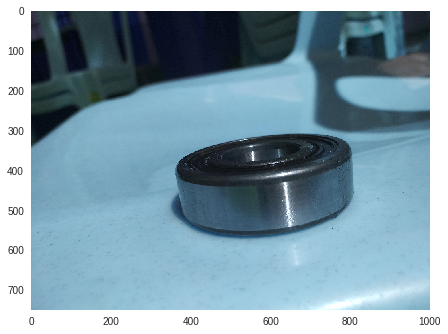

In [0]:
plt.grid(None)
plt.imshow(img2)

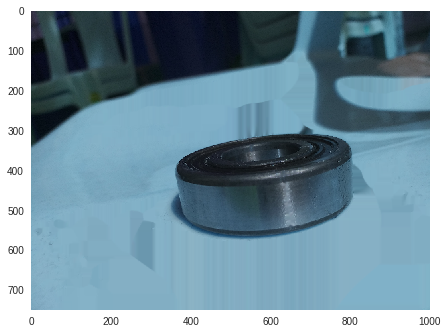

In [0]:
plt.grid(None)
plt.imshow(corrected2)

##Generating preprocessed dataset

### Function to preprocess images

In [0]:
def preprocess_img(path, res):
  img2 = cv2.resize(cv2.imread(path, cv2.IMREAD_COLOR),(1000,750), interpolation = cv2.INTER_CUBIC)
  h, s, v = cv2.split(cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)) # split into HSV components
  nonSat = s < 180 # Find all pixels that are not very saturated

  # Slightly decrease the area of the non-satuared pixels by a erosion operation.
  disk = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
  nonSat = cv2.erode(nonSat.astype(np.uint8), disk)

  # Set all brightness values, where the pixels are still saturated to 0.
  v2 = v.copy()
  v2[nonSat == 0] = 0;

  glare = v2 > 200;    # filter out very bright pixels.
  # Slightly increase the area for each pixel
  glare = cv2.dilate(glare.astype(np.uint8), disk);  
  glare = cv2.dilate(glare.astype(np.uint8), disk);

  corrected2 = cv2.inpaint(img2, glare, 5, cv2.INPAINT_NS)
  cv2.imwrite(res, corrected2)
  print("Generated "+res)

###Preprocessing both Positive and Negative examples and Generating final dataset for model
Importing side dataset

In [0]:
!mkdir -p dataset/false
!mkdir -p dataset/true

In [0]:
import os

directory = 'gdrive/My Drive/Dataset/False'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
        preprocess_img(os.path.join(directory, filename), 'dataset/false/'+filename)
    else:
        continue

Generated dataset/false/IMG_20190303_150146.jpg
Generated dataset/false/IMG_20190303_150436.jpg
Generated dataset/false/IMG_20190303_150434.jpg
Generated dataset/false/IMG_20190303_150428.jpg
Generated dataset/false/IMG_20190303_150149.jpg
Generated dataset/false/IMG_20190303_150131.jpg
Generated dataset/false/IMG_20190303_150127.jpg
Generated dataset/false/IMG_20190303_150445.jpg
Generated dataset/false/IMG_20190303_150443.jpg


In [0]:
directory = 'gdrive/My Drive/Dataset/True'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
        preprocess_img(os.path.join(directory, filename), 'dataset/true/'+filename)
    else:
        continue

Generated dataset/true/IMG_20190303_150522.jpg
Generated dataset/true/IMG_20190303_150246.jpg
Generated dataset/true/IMG_20190303_150233.jpg
Generated dataset/true/IMG_20190303_150528.jpg
Generated dataset/true/IMG_20190303_150526.jpg
Generated dataset/true/IMG_20190303_150525.jpg
Generated dataset/true/IMG_20190303_150524.jpg
Generated dataset/true/IMG_20190303_150244.jpg
Generated dataset/true/IMG_20190303_150243.jpg
Generated dataset/true/IMG_20190303_150242.jpg


Importing Top Dataset

In [0]:
import os

directory = 'gdrive/My Drive/Dataset2/False'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
        preprocess_img(os.path.join(directory, filename), 'dataset/false/'+filename)
    else:
        continue

Generated dataset/false/20190228_181135.jpg
Generated dataset/false/20190228_181114.jpg
Generated dataset/false/IMG_20190303_060625.jpg
Generated dataset/false/IMG_20190303_060708.jpg
Generated dataset/false/IMG_20190303_060701.jpg
Generated dataset/false/IMG_20190303_060658.jpg
Generated dataset/false/IMG_20190303_060645.jpg
Generated dataset/false/IMG_20190303_060621.jpg
Generated dataset/false/IMG_20190303_060649.jpg
Generated dataset/false/IMG_20190303_060630.jpg
Generated dataset/false/IMG_20190303_060615.jpg
Generated dataset/false/IMG_20190303_060653.jpg
Generated dataset/false/IMG_20190303_060529.jpg
Generated dataset/false/IMG_20190303_060513.jpg
Generated dataset/false/IMG_20190303_060327.jpg
Generated dataset/false/IMG_20190303_060454.jpg
Generated dataset/false/IMG_20190303_060421.jpg
Generated dataset/false/IMG_20190303_060414.jpg
Generated dataset/false/IMG_20190303_060407.jpg
Generated dataset/false/IMG_20190303_060425.jpg
Generated dataset/false/IMG_20190303_060335.jpg


In [0]:
import os

directory = 'gdrive/My Drive/Dataset2/True'

for filename in os.listdir(directory):
    if filename.endswith(".jpg"): 
        preprocess_img(os.path.join(directory, filename), 'dataset/true/'+filename)
    else:
        continue

Generated dataset/true/20190228_173219.jpg
Generated dataset/true/20190228_173203.jpg
Generated dataset/true/20190228_173228.jpg
Generated dataset/true/IMG_20190303_055834.jpg
Generated dataset/true/IMG_20190303_055623.jpg
Generated dataset/true/IMG_20190303_055637.jpg
Generated dataset/true/IMG_20190303_055634.jpg
Generated dataset/true/IMG_20190303_055533.jpg
Generated dataset/true/IMG_20190303_055607.jpg
Generated dataset/true/IMG_20190303_055531.jpg
Generated dataset/true/IMG_20190303_055602.jpg
Generated dataset/true/IMG_20190303_055558.jpg
Generated dataset/true/IMG_20190303_055604.jpg
Generated dataset/true/IMG_20190303_055552.jpg
Generated dataset/true/IMG_20190303_055852.jpg
Generated dataset/true/IMG_20190303_055543.jpg
Generated dataset/true/IMG_20190303_055548.jpg
Generated dataset/true/IMG_20190303_055837.jpg
Generated dataset/true/IMG_20190303_055843.jpg
Generated dataset/true/IMG_20190303_055758.jpg
Generated dataset/true/IMG_20190303_055736.jpg
Generated dataset/true/IM

# Creating the Model

##Xception Model for Side View

### Keras Model and Summary

In [0]:
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(512,activation = 'relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(base_model.input, predictions)

#print(model.summary())

for layer in base_model.layers:
  layer.trainable = False

print(model.summary())

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 1s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1

### Loading pre-trained weights if available

In [0]:
model.load_weights('model-20.h5')

### Generating model graphics

In [0]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

## Xception Model for Top View

In [0]:
from keras.applications.xception import Xception
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model

base_model = Xception(input_shape=(299, 299, 3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(512,activation = 'relu')(x)
predictions = Dense(2, activation='softmax')(x)

model2 = Model(base_model.input, predictions)

#print(model.summary())

for layer in base_model.layers:
  layer.trainable = False

print(model2.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

# Fitting the Model

##Side View

### Keras ImageDataGenerator
- Provides Data Augmentation (Scaling, Rotation, Skews, Flips etc)
- Supplies images to the model in batches after augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

transformation_ratio = 0.2
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=transformation_ratio,
                                       shear_range=transformation_ratio,
                                       zoom_range=transformation_ratio,
                                       cval=transformation_ratio,
                                       horizontal_flip=True,
                                       vertical_flip=True)

train_generator = train_datagen.flow_from_directory('dataset',
                                                     target_size=(299, 299),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

Found 64 images belonging to 2 classes.


### Compile the model
Loss is cross-entropy and we have used the adam optimizer

In [0]:
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])


### Fit the model for 10 epochs

In [0]:
history = model.fit_generator(train_generator,
                    steps_per_epoch = 100,
                    nb_epoch=10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=100, epochs=20)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
100/100 [==============================] - 41s 410ms/step - loss: 0.4343 - acc: 0.8150
Epoch 2/20
100/100 [==============================] - 33s 326ms/step - loss: 0.2716 - acc: 0.9100
Epoch 3/20
100/100 [==============================] - 33s 327ms/step - loss: 0.2211 - acc: 0.9200
Epoch 4/20
100/100 [==============================] - 32s 325ms/step - loss: 0.1777 - acc: 0.9475
Epoch 5/20
100/100 [==============================] - 32s 322ms/step - loss: 0.1571 - acc: 0.9488
Epoch 6/20
100/100 [==============================] - 33s 326ms/step - loss: 0.1480 - acc: 0.9488
Epoch 7/20
100/100 [==============================] - 32s 323ms/step - loss: 0.1286 - acc: 0.9613
Epoch 8/20
100/100 [==============================] - 32s 323ms/step - loss: 0.1350 - acc: 0.9513
Epoch 9/20
100/100 [==============================] - 32s 323ms/step - loss: 0.1184 - acc: 0.9625
Epoch 10/20
100/100 [==============================] - 32s 319ms/step - loss: 0.1169 - acc: 0.9587
Epoch 11/20
100/100

### Save trained weights

In [0]:
model.save_weights('model-20.h5')

### Plot Model Statistics during training

In [0]:
print(history.history.keys())

dict_keys(['loss', 'acc'])


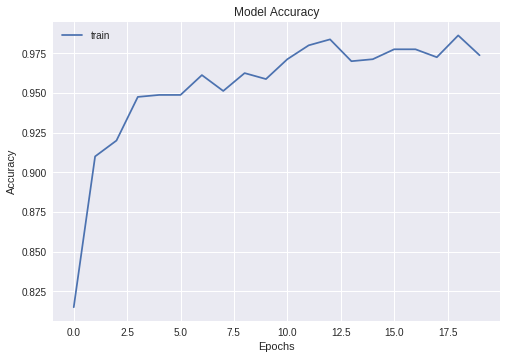

In [0]:
# Accuracy
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'], loc='upper left')
plt.show()

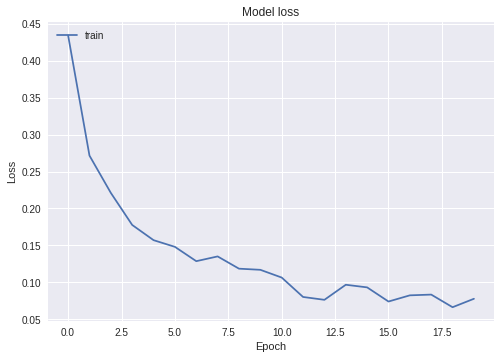

In [0]:
# Loss
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [0]:
#img_test = cv2.imread('IMG_20190302_103542-2.jpg', cv2.IMREAD_COLOR)
#preprocess_img('IMG_20190302_103542-2.jpg', 'IMG_20190302_103542-2-pre.jpg')
img_test = cv2.resize(cv2.imread('IMG_20190302_103542-2-pre.jpg', cv2.IMREAD_COLOR),(299,299), interpolation = cv2.INTER_CUBIC)

y = model.predict(img_test.reshape(1, img_test.shape[0], img_test.shape[1], img_test.shape[2]))
print(y)

[[2.8406012e-06 9.9999714e-01]]


## Top View

### ImageDataGenerator 

In [0]:
from keras.preprocessing.image import ImageDataGenerator

transformation_ratio = 0.2
batch_size = 8

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=transformation_ratio,
                                       shear_range=transformation_ratio,
                                       zoom_range=transformation_ratio,
                                       cval=transformation_ratio,
                                       horizontal_flip=True,
                                       vertical_flip=True)

train_generator = train_datagen.flow_from_directory('dataset',
                                                     target_size=(299, 299),
                                                     batch_size=batch_size,
                                                     class_mode='categorical')

Found 71 images belonging to 2 classes.


### Compile and Fit

In [0]:
model2.compile(optimizer='adam',
                  loss='categorical_crossentropy',  # categorical_crossentropy if multi-class classifier
                  metrics=['accuracy'])

In [0]:
history2 = model2.fit_generator(train_generator,
                      steps_per_epoch = 100,
                      nb_epoch=20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=100, epochs=20)`
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/20
100/100 [==============================] - 32s 321ms/step - loss: 0.1323 - acc: 0.9493
Epoch 2/20
100/100 [==============================] - 32s 316ms/step - loss: 0.1008 - acc: 0.9698
Epoch 3/20
100/100 [==============================] - 32s 315ms/step - loss: 0.1246 - acc: 0.9607
Epoch 4/20
100/100 [==============================] - 31s 314ms/step - loss: 0.0860 - acc: 0.9691
Epoch 5/20
100/100 [==============================] - 31s 315ms/step - loss: 0.1101 - acc: 0.9643
Epoch 6/20
100/100 [==============================] - 32s 315ms/step - loss: 0.1135 - acc: 0.9602
Epoch 7/20
100/100 [==============================] - 32s 316ms/step - loss: 0.0675 - acc: 0.9818
Epoch 8/20
100/100 [==============================] - 32s 317ms/step - loss: 0.0745 - acc: 0.9739
Epoch 9/20
100/100 [==============================] - 31s 314ms/step - loss: 0.1010 - acc: 0.9600
Epoch 10/20
100/100 [==============================] - 31s 313ms/step - loss: 0.0831 - acc: 0.9762
Epoch 11/20
100/100

In [0]:
model2.save_weights('model2-20.h5')

### Plotting Model 

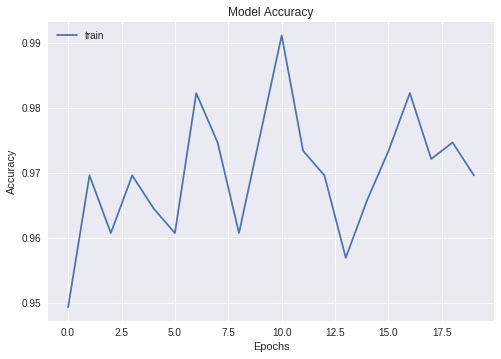

In [0]:
# Accuracy
plt.plot(history2.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train'], loc='upper left')
plt.show()

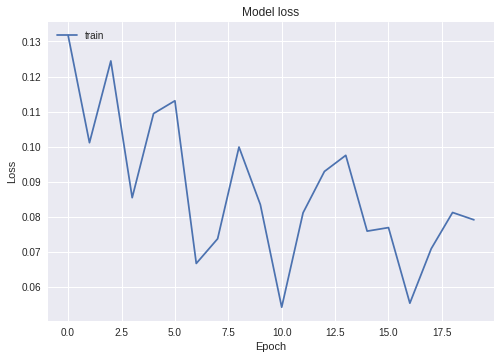

In [0]:
# Loss
plt.plot(history2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

The probabaility of the bearing being non defective is: 2.84 * 10^-6 (approx 0)
The probabaility of the bearing being defective is: 0.99

The system has successfully classified defective bearing image.


# Testing the Model

### Display the three test images

Two side view images

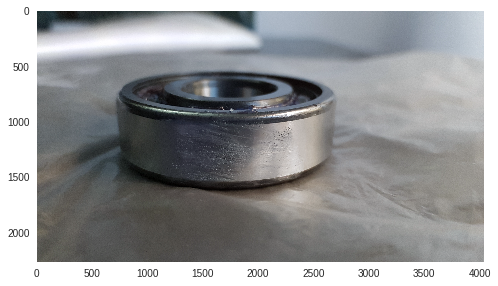

In [0]:
im = cv2.imread('20190228_180259.jpg', cv2.IMREAD_COLOR)
plt.grid(None)
plt.imshow(im)

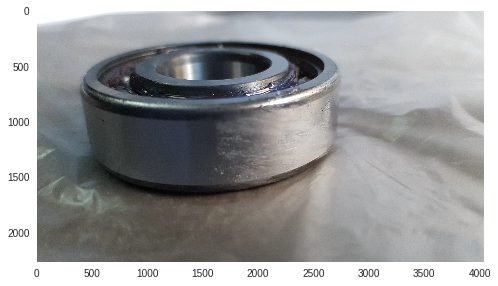

In [0]:
im = cv2.imread('20190228_180312.jpg', cv2.IMREAD_COLOR)
plt.grid(None)
plt.imshow(im)

Top view

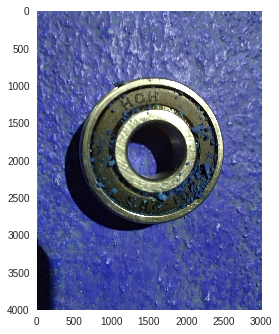

In [0]:
im = cv2.imread('IMG_20190303_060056.jpg', cv2.IMREAD_COLOR)
plt.grid(None)
plt.imshow(im)

## Function to make predictions

We take two images for side view from different perspective and pass them through the side-view model. Then we take the average of their predictions.

The top view image is run through the top-view model.

These predictions are used for classifying whether the bearing is defective or not.

In [0]:
def make_predictions(img1, img2, img3, threshold_top = 0.8, threshold_side = 0.8):
  
  preprocess_img(img1, 'img1-pre.jpg')
  img_test1 = cv2.resize(cv2.imread('img1-pre.jpg', cv2.IMREAD_COLOR),(299,299), interpolation = cv2.INTER_CUBIC)
  y1 = model.predict(img_test1.reshape(1, img_test1.shape[0], img_test1.shape[1], img_test1.shape[2]))
  
  preprocess_img(img2, 'img2-pre.jpg')
  img_test2 = cv2.resize(cv2.imread('img2-pre.jpg', cv2.IMREAD_COLOR),(299,299), interpolation = cv2.INTER_CUBIC)
  y2 = model.predict(img_test2.reshape(1, img_test2.shape[0], img_test2.shape[1], img_test2.shape[2]))
  
  pred1 = (y1+y2)/2
  print("Side face Results:")
  
  if pred1[0][0] >= threshold_side:
    print("Non-Defective Bearing")
  else:
    print("Defective bearing")
  
  preprocess_img(img3, 'img3-pre.jpg')
  img_test3 = cv2.resize(cv2.imread('img3-pre.jpg', cv2.IMREAD_COLOR),(299,299), interpolation = cv2.INTER_CUBIC)
  pred2 = model2.predict(img_test3.reshape(1, img_test3.shape[0], img_test3.shape[1], img_test3.shape[2]))
  
  print("Top face Results:")
  
  if pred2[0][0] >= threshold_top:
    print("Non-Defective Bearing")
  else:
    print("Defective bearing")

## Making predictions on test images

In [0]:
make_predictions('20190228_180259.jpg', '20190228_180312.jpg', 'IMG_20190303_060056.jpg')

Generated img1-pre.jpg
Generated img2-pre.jpg
Side face Results:
Defective bearing
Generated img3-pre.jpg
Top face Results:
Defective bearing


##Testing a single image on side-model

### Function

In [0]:
def test_image(img, threshold = 0.5):
  preprocess_img(img, 'img-pre.jpg')
  img_test = cv2.resize(cv2.imread('img-pre.jpg', cv2.IMREAD_COLOR),(299,299), interpolation = cv2.INTER_CUBIC)
  y = model.predict(img_test.reshape(1, img_test.shape[0], img_test.shape[1], img_test.shape[2]))
  
  im = cv2.imread(img, cv2.IMREAD_COLOR)
  plt.grid(None)
  plt.imshow(im)
  
  print("Result for Image:")
  print(y)
  
  if y[0][0] <= threshold:
    print("Non-Defective Bearing")
  else:
    print("Defective bearing")

### Some test examples

In [0]:
test_image('small.jpg')

NameError: ignored

Generated img-pre.jpg
Result for Image:
[[9.060621e-11 1.000000e+00]]
Non-Defective Bearing


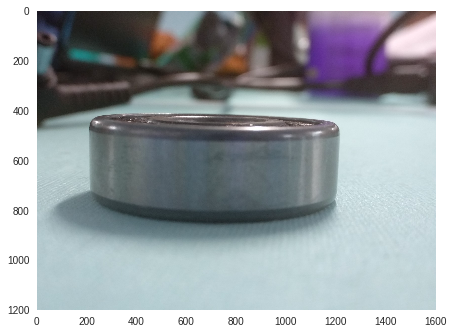

In [0]:
test_image('middle.jpg')

Generated img-pre.jpg
Result for Image:
[[6.5868076e-06 9.9999344e-01]]
Non-Defective Bearing


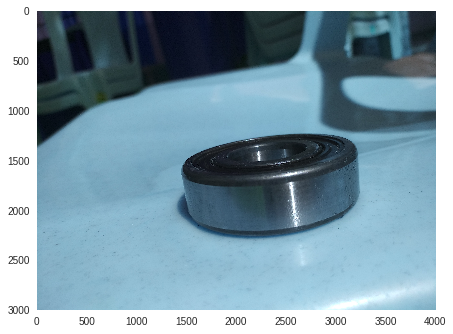

In [0]:
test_image('Oil-NonDefect.jpg')

Generated img-pre.jpg
Result for Image:
[[4.3515166e-10 1.0000000e+00]]
Non-Defective Bearing


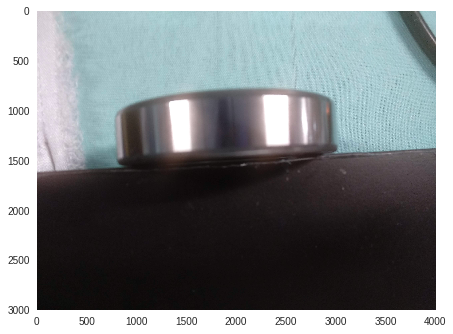

In [0]:
test_image('none.jpg')

Generated img-pre.jpg
Result for Image:
[[9.996739e-05 9.999000e-01]]
Non-Defective Bearing


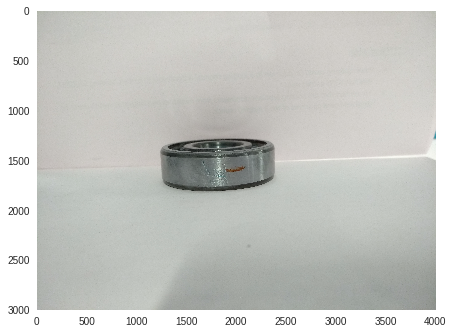

In [0]:
test_image('bad.jpg')

Generated img-pre.jpg
Result for Image:
[[1.0000000e+00 1.4755383e-15]]
Defective bearing


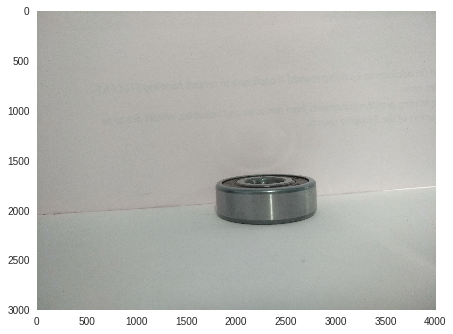

In [0]:
test_image('good.jpg')